In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)

!pip install pandas==0.25.3

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [ ]:
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])


df_movies = movies 
df_ratings = ratings

<BarContainer object of 19 artists>

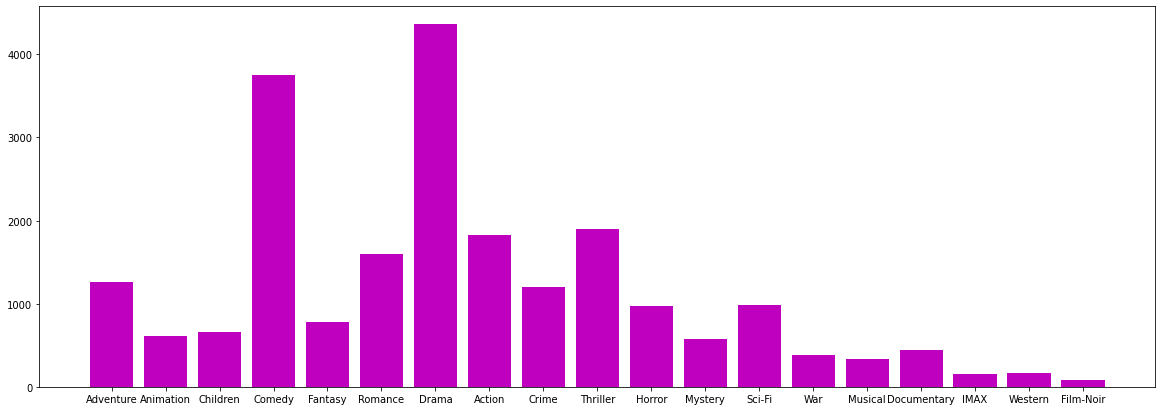

In [ ]:
#most popular genres
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score


In [ ]:
def scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)


def clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg drama rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_comedy_rating'], clustered['avg_drama_rating'], c=clustered['group'], s=20, cmap=cmap)

        
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)


def genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
    
def dataset_3(movies, ratings, genre_ratings):    
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_drama_rating', 'avg_comedy_rating', 'avg_action_rating']
    
    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_drama_rating'] < b1 - 0.2) & (genre_ratings_3['avg_comedy_rating'] > b2)) | ((genre_ratings_3['avg_comedy_rating'] < b1) & (genre_ratings_3['avg_drama_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())
    
    return biased_dataset_3

def clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg drama rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_comedy_rating'], 
                        point['avg_drama_rating'], 
                        s=size, 
                        color=color)
    
def movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break
                
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
    
def movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()
    
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_drama_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_comedy_rating'] > score_limit_2)) | 
                                   ((genre_ratings['avg_comedy_rating'] < score_limit_1) & (genre_ratings['avg_drama_rating'] > score_limit_2)) ]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [ ]:
# Calculate the average rating of 2 most common genres movies

genre_ratings = genre_ratings(ratings, movies, ['Drama', 'Comedy', 'Action'], ['avg_drama_rating', 'avg_comedy_rating', 'avg_action_rating'])
print( "Number of records: ", len(genre_ratings))

genre_ratings.head()

Number of records:  610


,avg_drama_rating,avg_comedy_rating,avg_action_rating
1,4.53,4.28,4.32
2,3.88,4.00,3.95
3,0.75,1.00,3.57
4,3.48,3.51,3.32
5,3.80,3.47,3.11


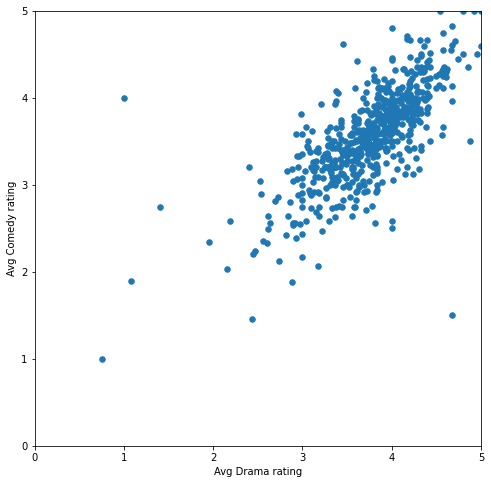

In [ ]:
%matplotlib inline

scatterplot(genre_ratings['avg_drama_rating'],'Avg Drama rating', genre_ratings['avg_comedy_rating'], 'Avg Comedy rating')

In [ ]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_drama_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_comedy_rating'] > score_limit_2)) | 
                                   ((genre_ratings['avg_comedy_rating'] < score_limit_1) & (genre_ratings['avg_drama_rating'] > score_limit_2)) ]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [ ]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  131


,index,avg_drama_rating,avg_comedy_rating,avg_action_rating
0,7,3.13,3.16,3.26
1,14,3.71,2.71,3.33
2,19,2.61,2.64,2.73
3,21,2.95,3.20,3.46
4,22,2.61,2.49,2.78


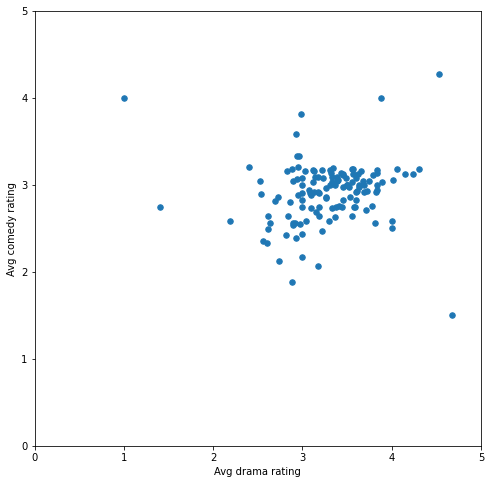

In [ ]:
%matplotlib inline

scatterplot(biased_dataset['avg_drama_rating'],'Avg drama rating', biased_dataset['avg_comedy_rating'], 'Avg comedy rating')

In [ ]:
# Let's turn our dataset into a list
biased_list = biased_dataset[['avg_drama_rating','avg_comedy_rating']].values

0.385771397400849

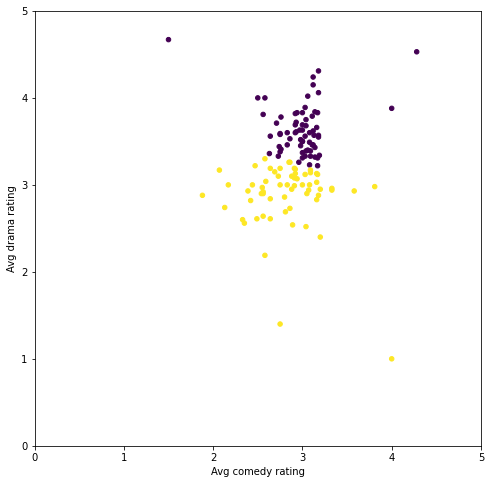

In [ ]:

from sklearn.cluster import KMeans 

kmeans_1 = KMeans(n_clusters=2)

predictions = kmeans_1.fit_predict(biased_list)


clusters(biased_dataset, predictions)
clustering_errors(2, biased_list)

0.39436177541431655

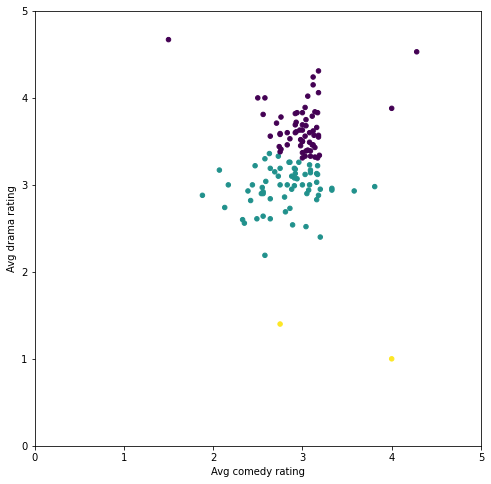

In [ ]:

kmeans_3 = KMeans(n_clusters =3)


predictions_3 = kmeans_3.fit_predict(biased_list)


clusters(biased_dataset, predictions_3)
clustering_errors(3, biased_list)

Now the average scifi rating is starting to come into play. The groups are:

people who like romance but not scifi
people who like scifi but not romance
people who like both scifi and romance
people who like dont like both

In [ ]:
# Choose the range of k values to test.

possible_k_values = range(2, len(biased_list)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, biased_list) for k in possible_k_values]


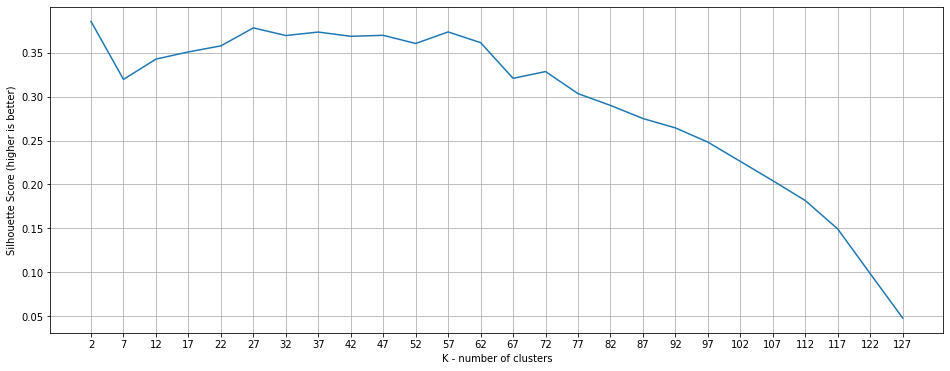

In [ ]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

0.3425499546606445

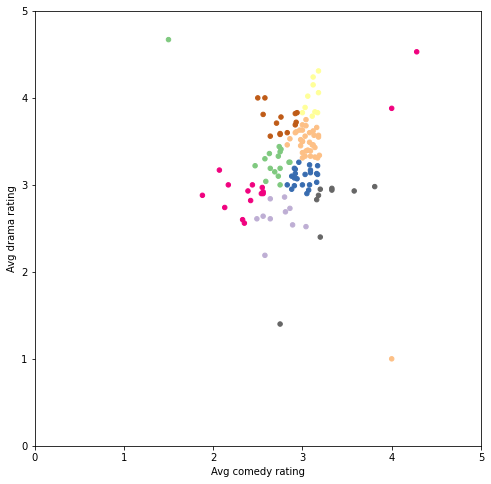

In [ ]:
 #KMeans to find seven clusters
kmeans_7 = KMeans(n_clusters=12)


predictions_7 = kmeans_7.fit_predict(biased_list)

clusters(biased_dataset, predictions_7, cmap='Accent') 
clustering_errors(12, biased_list)

In [ ]:
def genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings


In [ ]:
biased_dataset_3_genres = genre_ratings(ratings, movies, ['Drama', 'Comedy', 'Action', 'Thriller'], ['avg_drama_rating', 'avg_comedy_rating', 'avg_action_rating', 'avg_thriller_rating'])
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  130


,index,avg_drama_rating,avg_comedy_rating,avg_action_rating,avg_thriller_rating
0,7,3.13,3.16,3.26,3.43
1,14,3.71,2.71,3.33,3.46
2,19,2.61,2.64,2.73,2.55
3,21,2.95,3.20,3.46,3.55
4,22,2.61,2.49,2.78,2.78


In [ ]:
biased_list_action = biased_dataset_3_genres[['avg_comedy_rating',
                                         'avg_drama_rating', 
                                         'avg_action_rating', 'avg_thriller_rating']].values

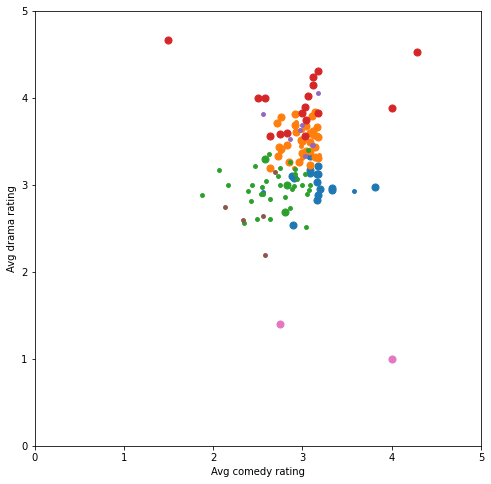

In [ ]:
# KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)


predictions_5 = kmeans_5.fit_predict(biased_list_action)


clusters_3d(biased_dataset_3_genres, predictions_5)

In [74]:
# Merge the two tables 
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
print(ratings_title)
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\n example:')
user_movie_ratings.iloc[:6, :10]

        userId  movieId  rating   timestamp                             title
0            1        1     4.0   964982703                  Toy Story (1995)
1            5        1     4.0   847434962                  Toy Story (1995)
2            7        1     4.5  1106635946                  Toy Story (1995)
3           15        1     2.5  1510577970                  Toy Story (1995)
4           17        1     4.5  1305696483                  Toy Story (1995)
...        ...      ...     ...         ...                               ...
100831     610   160341     2.5  1479545749                  Bloodmoon (1997)
100832     610   160527     4.5  1479544998  Sympathy for the Underdog (1971)
100833     610   160836     3.0  1493844794                     Hazard (2005)
100834     610   163937     3.5  1493848789                Blair Witch (2016)
100835     610   163981     3.5  1493850155                         31 (2016)

[100836 rows x 5 columns]
dataset dimensions:  (610, 9719) 

 e

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


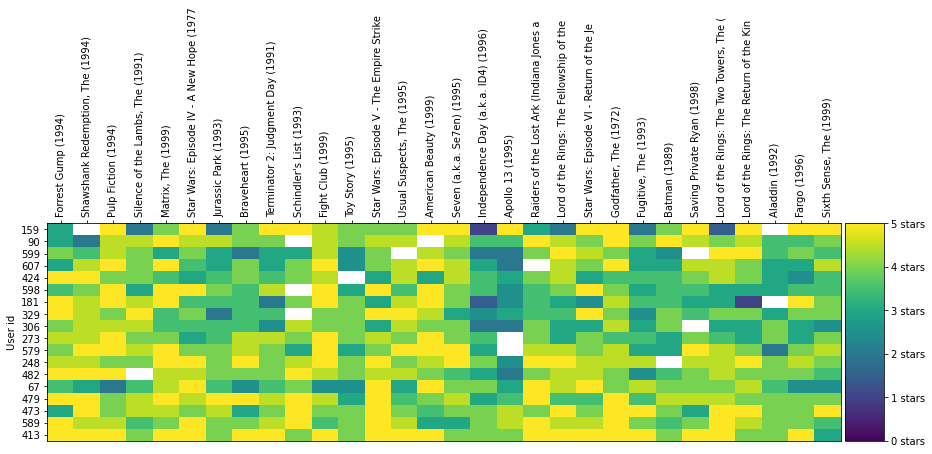

In [ ]:
movies_heatmap(most_rated_movies_users_selection)

In [105]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= ['title'], values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [106]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [107]:
# 15 clusters
predictions = KMeans(n_clusters=15, algorithm='full').fit_predict(sparse_ratings)

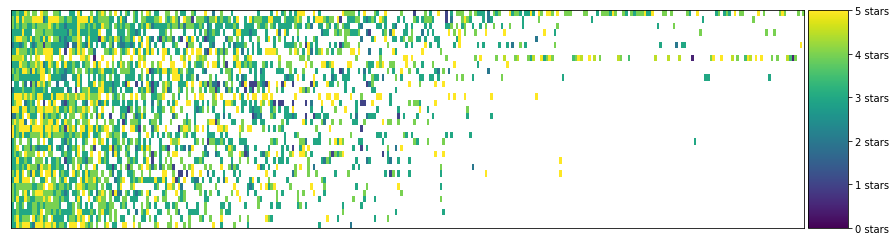

In [110]:
max_users = 100
max_movies = 100

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# The below line could be used to visualize the cluster

# You can view the cluster by putting its number individually
# TODO: Pick a cluster ID from the clusters above
cluster_number = 7



# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster =sort_by_rating_density(cluster, n_movies, n_users)
movies_heatmap(cluster, axis_labels=False)

In [111]:
cluster.fillna('').head()

,True Lies (1994),Batman (1989),"Fugitive, The (1993)",Die Hard: With a Vengeance (1995),Jurassic Park (1993),Apollo 13 (1995),"Firm, The (1993)","Mask, The (1994)",Dances with Wolves (1990),Speed (1994),...,M*A*S*H (a.k.a. MASH) (1970),"Graduate, The (1967)",Stand by Me (1986),RoboCop (1987),American Pie (1999),Scream (1996),Shakespeare in Love (1998),Citizen Kane (1941),2001: A Space Odyssey (1968),Rear Window (1954)
5,3,3,4,3,3,5,4,,4,4,...,4,5,4,,,,,4,,4
0,4,3,5,3,5,4,4,4,5,5,...,,,,,,,,,,
7,4,3,4,3,4,4,3,3,4,3,...,,,,,,,,,,
27,3,3,3,3,5,3,3,3,,4,...,,,,,,,,,,
32,3,4,5,5,4,4,3,5,3,4,...,,,,,,,,,,


In [96]:

# Pick a movie from the table above since we're looking at a subset of dataset
movie_name = "Willow (1988)"

print('Predicted rating:',cluster[movie_name].mean())

KeyError: ignored

In [112]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

True Lies (1994)                     3.378788
Batman (1989)                        3.469697
Fugitive, The (1993)                 4.227273
Die Hard: With a Vengeance (1995)    3.564516
Jurassic Park (1993)                 4.161290
Apollo 13 (1995)                     3.916667
Firm, The (1993)                     3.700000
Mask, The (1994)                     3.366667
Dances with Wolves (1990)            3.800000
Speed (1994)                         3.783333
Lion King, The (1994)                4.033333
Forrest Gump (1994)                  4.433333
Pulp Fiction (1994)                  3.633333
Sleepless in Seattle (1993)          3.931034
Braveheart (1995)                    4.517241
Aladdin (1992)                       3.879310
Clear and Present Danger (1994)      3.689655
Mrs. Doubtfire (1993)                3.750000
Pretty Woman (1990)                  3.428571
Star Trek: Generations (1994)        3.285714
dtype: float64

In [115]:
#finding movies for user based in that cluster they did not rate
user_id = 32
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

print("Total recommended movies are: ", len(avg_ratings), '\n\n')
print ("Top 30 movies are: ", '\n') 
avg_ratings.sort_values(ascending=False)[:30]


Total recommended movies are:  196 


Top 30 movies are:  



Miss Congeniality (2000)                                  5.000000
When Harry Met Sally... (1989)                            5.000000
You've Got Mail (1998)                                    5.000000
Cool Hand Luke (1967)                                     5.000000
Bodyguard, The (1992)                                     5.000000
Patton (1970)                                             5.000000
Lethal Weapon 3 (1992)                                    5.000000
Philadelphia Story, The (1940)                            5.000000
How to Lose a Guy in 10 Days (2003)                       5.000000
2001: A Space Odyssey (1968)                              5.000000
Manchurian Candidate, The (1962)                          5.000000
Underworld (2003)                                         5.000000
Wallace & Gromit: The Best of Aardman Animation (1996)    5.000000
Graduate, The (1967)                                      5.000000
Glory (1989)                                              5.00

In [114]:
type(avg_ratings)

pandas.core.series.Series

In [86]:
avg_ratings.to_csv('reccomendations.csv', header="True")

In [87]:
from google.colab import files
files.download('reccomendations.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>